In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv

from os.path import join

plt.rcParams['figure.figsize'] = [8, 8]
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

### Pre-Processing

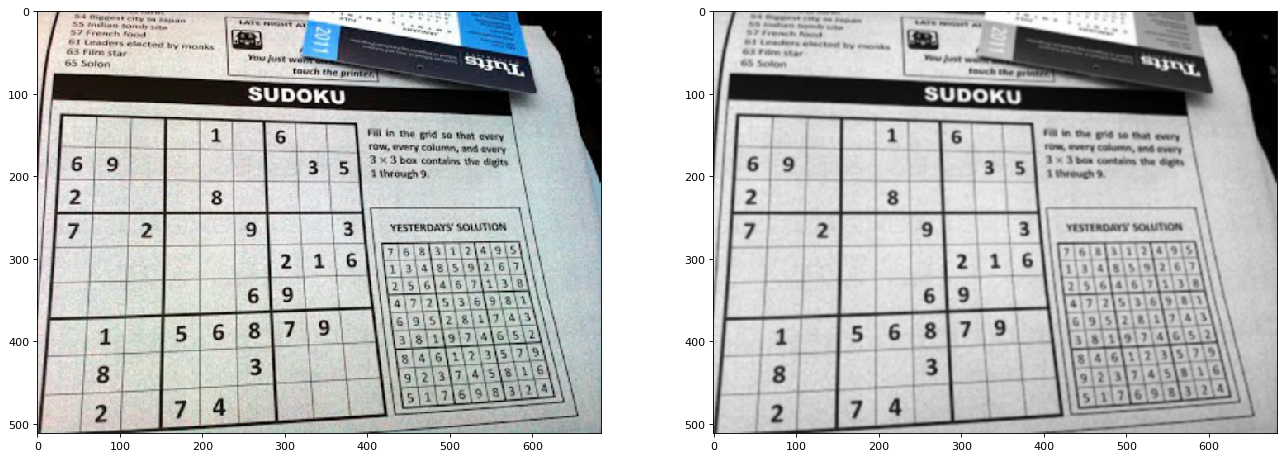

In [231]:
#Pre-processing
imgpath = "./test_imgs/";
img = cv.imread(join(imgpath, "sudoku3.jpg"));

#Resize image such that minimum of its dimension = 512
rows,cols,ch = img.shape
k = 512/min(rows, cols)
img = cv.resize(img, (0,0), fx=k, fy=k)
rows,cols,ch = img.shape

#Convert to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY);

#Smoothing to remove any extra noise
# dim = int(max(min(rows, cols)/100, 1))
# if dim%2 == 0:
#     dim = dim + 1
dim = 5
img_gray = cv.GaussianBlur(img_gray,(dim,dim),0)
# img_gray = cv.medianBlur(img_gray, dim)

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(img);
plt.subplot(122); plt.imshow(img_gray, 'gray')
plt.show()

### Adaptive Thresholding (Binarizing the Image)

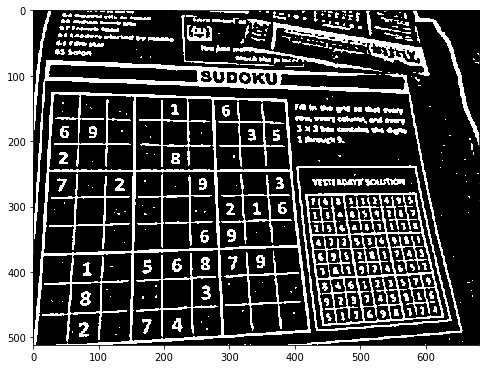

In [232]:
#Adaptive Thresholding
bw = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21, 7);
plt.imshow(bw, 'gray')
plt.show()

### Noise Removal (using Morphological Opening)

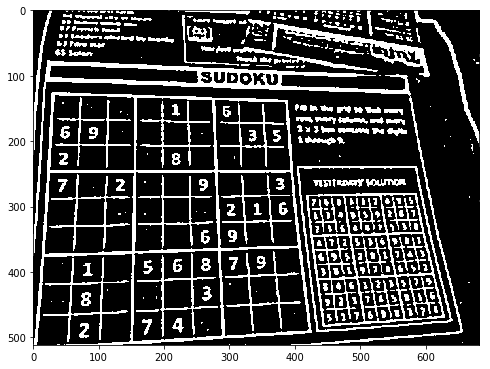

In [233]:
#Noise Removal (Morphological Opening)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2));
opened = cv.morphologyEx(bw, cv.MORPH_OPEN, kernel);
plt.imshow(opened, 'gray')
plt.show()

### Extracting the Grid (Largest Connected Component)

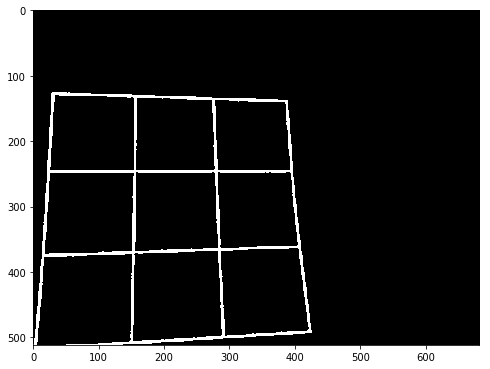

In [234]:
#Largest Connected Component
def largest_CC (image, disp):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    
    max_size = 0 
    img2 = np.zeros((1,1))
    if len(sizes)>1:
        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]

        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255
        if disp:
            plt.imshow(img2, 'gray')
            plt.show()
        
    return img2, max_size

grid, s = largest_CC(opened, 1)
grid = grid.astype(np.uint8)
# print(s)

### Morphological Closing (to strength the boundaries)

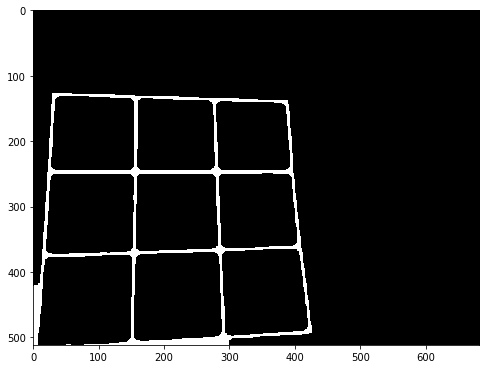

In [235]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20));
closed_grid = cv.morphologyEx(grid, cv.MORPH_CLOSE, kernel);
closed_grid = closed_grid.astype(np.uint8)
plt.imshow(closed_grid, 'gray')
plt.show()

### Applying Hough Transform (to identify lines)

In [126]:
def takeFirst(elem):
    return abs(elem[0])

In [236]:
# Hough Transform 1 (Extracting the boundaries)
closed_grid = closed_grid.astype(np.uint8)

# This returns an array of r and theta values 
lines = cv.HoughLines(grid, 1, np.pi/180, 200)

sortedlines = []
for line in lines:
    for rho,theta in line:
        sortedlines+=[(rho, theta)]

# sort list with key
sortedlines.sort(key=takeFirst)

#Seperate the boundary lines
res = 0.3      #Resolution for theta

#First Minimum
first_min = sortedlines[0]

#Seconod Minimum
for i in range(1,len(sortedlines)):
    l = sortedlines[i]
    if (l[1] >= first_min[1] + res) or (l[1] <= first_min[1] - res):
            second_min = l
            break

#First Maximum
first_max = sortedlines[-1]

#Second Maximum
for i in range(len(sortedlines)-2, 0, -1):
    l = sortedlines[i]
    if (l[1] >= first_max[1] + res) or (l[1] <= first_max[1] - res):
            second_max = l
            break

#Boundary lines
boundaries = [first_min, second_min, first_max, second_max]

# print(sortedlines)
# print(boundaries)

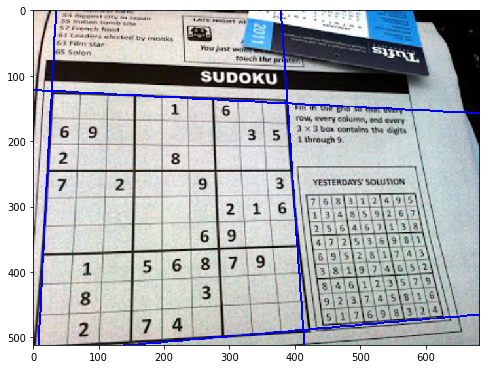

In [237]:
# Hough Transform 2 (Overlaying the lines)
overlay = img.copy()

# The below for loop runs till r and theta values 
# are in the range of the 2d array 
for line in boundaries:
    r = line[0]
    theta = line[1]
    
    # Stores the value of cos(theta) in a 
    a = np.cos(theta) 

    # Stores the value of sin(theta) in b 
    b = np.sin(theta) 

    # x0 stores the value rcos(theta) 
    x0 = a*r 

    # y0 stores the value rsin(theta) 
    y0 = b*r 

    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta)) 
    x1 = int(x0 + 3000*(-b)) 

    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta)) 
    y1 = int(y0 + 3000*(a)) 

    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta)) 
    x2 = int(x0 - 3000*(-b)) 

    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta)) 
    y2 = int(y0 - 3000*(a)) 

    # draw a line in img from the point(x1,y1) to (x2,y2).
    cv.line(overlay,(x1,y1),(x2,y2),(0,0,255),2)

#Display the result
plt.imshow(overlay)
plt.show()

In [238]:
#Helper function
def segregateBoundLines(lines):
    hl = [lines[0]]
    vl = [lines[1]]
    theta_diff = abs(lines[0][1]-lines[2][1])
    
    #Seperate the parallel lines
    if theta_diff < 0.1 or theta_diff > 2.9:
        hmax = 2
        vmax = 3
    else:
        hmax = 3
        vmax = 2

    hl += [lines[hmax]]
    vl += [lines[vmax]]

    # Swap if assigned wrongly
    if hl[0][1] > vl[0][1]:
        temp = vl
        vl = hl
        hl = temp
    
    return hl,vl

# https://stackoverflow.com/a/383527/5087436
def intersectionPoints(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0] 

In [239]:
#Segregate all the Boundary Lines into Horizontal and Vertical (Relatively)
hor_lines, vert_lines = segregateBoundLines(boundaries)
print(hor_lines)
print(vert_lines)

#Intersection points
pts1 = []
pts1 += [intersectionPoints(hor_lines[0], vert_lines[0])]
pts1 += [intersectionPoints(hor_lines[1], vert_lines[0])]
pts1 += [intersectionPoints(hor_lines[0], vert_lines[1])]
pts1 += [intersectionPoints(hor_lines[1], vert_lines[1])]
pts1 = np.float32(np.array(pts1))

#Desired points
pts2 = np.float32([[0,0], [rows,0], [0,cols], [rows,cols]])

print(pts1)
print(pts2)

[(35.0, 0.05235988), (-378.0, 3.0717795)]
[(122.0, 1.6231562), (523.0, 1.4835298)]
[[ 29. 124.]
 [389. 143.]
 [  8. 524.]
 [413. 489.]]
[[  0.   0.]
 [512.   0.]
 [  0. 683.]
 [512. 683.]]


### Step 7: Unwarping the Image

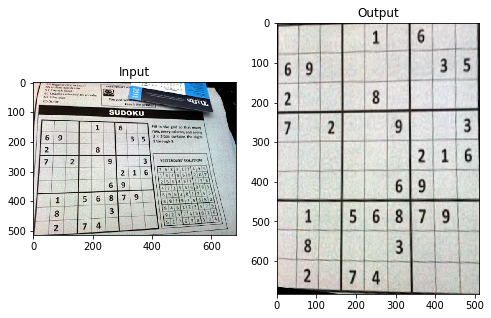

In [240]:
#Get the affine transform from the pts
forward = cv.getPerspectiveTransform(pts1,pts2)
backward = cv.getPerspectiveTransform(pts2,pts1)

#Apply the transform
sudoku = cv.warpPerspective(img, forward, (rows,cols))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(sudoku, 'gray'),plt.title('Output')
plt.show()

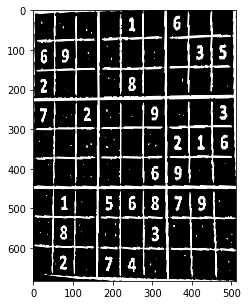

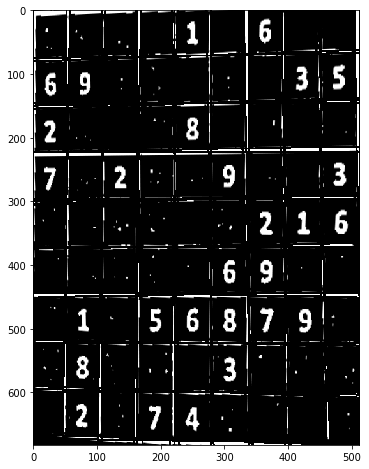

In [243]:
sudoku_bw = cv.warpPerspective(bw, forward, (rows,cols))
plt.subplot(121)
plt.imshow(sudoku_bw, 'gray')
plt.show()

# This returns an array of r and theta values 
lines = cv.HoughLines(sudoku_bw, 1, np.pi/180, 350)

sortedlines = []
for line in lines:
    for rho,theta in line:
        sortedlines+=[(rho, theta)]

# sort list with key
# sortedlines.sort(key=takeFirst)

# Hough Transform 2 (Overlaying the lines)
overlay = sudoku_bw.copy()

# The below for loop runs till r and theta values 
# are in the range of the 2d array 
for line in sortedlines:
    r = line[0]
    theta = line[1]
    
    # Stores the value of cos(theta) in a 
    a = np.cos(theta) 

    # Stores the value of sin(theta) in b 
    b = np.sin(theta) 

    # x0 stores the value rcos(theta) 
    x0 = a*r 

    # y0 stores the value rsin(theta) 
    y0 = b*r 

    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta)) 
    x1 = int(x0 + 3000*(-b)) 

    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta)) 
    y1 = int(y0 + 3000*(a)) 

    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta)) 
    x2 = int(x0 - 3000*(-b)) 

    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta)) 
    y2 = int(y0 - 3000*(a)) 

    # draw a line in img from the point(x1,y1) to (x2,y2).
    cv.line(overlay,(x1,y1),(x2,y2),(0,0,0),2)

#Display the result
plt.imshow(overlay, 'gray')
plt.show()

### Digit Classification

In [114]:
################################################### TODO ######################################
#Train NN on MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.2022 - acc: 0.9408
Epoch 2/5
60000/60000 [==============================] - 15s 244us/step - loss: 0.0819 - acc: 0.9748
Epoch 3/5
60000/60000 [==============================] - 14s 230us/step - loss: 0.0529 - acc: 0.9837
Epoch 4/5
60000/60000 [==============================] - 14s 228us/step - loss: 0.0372 - acc: 0.9879
Epoch 5/5
10000/10000 [==============================] - 1s 71us/step


[0.07619646628187621, 0.9784]

In [218]:
def display_matrix(grid):
    for i in range(9):
        string = ""
        for j in range(9):
            string += str(grid[i][j]) + " "
        print(string)

def is_empty(block):
    lcc, size = largest_CC(block,0)
    m,n = block.shape
    ratio = size/(m*n)
    if ratio < 0.07:
        ################################### TODO ###############################
        return True
    return False

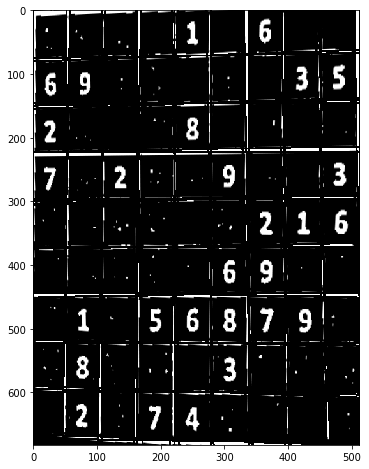

75.88888888888889 56.888888888888886
6 6 0 0 8 0 8 0 0 
0 8 0 0 0 0 0 8 8 
2 0 0 0 8 0 0 0 0 
7 0 7 0 0 8 0 0 4 
0 0 0 0 0 0 4 3 9 
0 0 0 0 0 9 9 0 0 
0 4 0 8 8 9 3 9 0 
0 8 0 0 0 4 0 0 0 
0 4 0 7 8 0 0 0 0 


In [246]:
#Display the underlying matrix
plt.imshow(overlay, 'gray')
plt.show()

#Divide into blocks
mat = np.zeros((9,9), dtype=np.int)
r,c = overlay.shape
x_steps = r/9
y_steps = c/9
print(x_steps, y_steps)
for i in range(9):
    x1 = np.int16(i*x_steps)
    x2 = np.int16((i+1)*x_steps)
    for j in range(9):
        y1 = np.int16(j*y_steps)
        y2 = np.int16((j+1)*y_steps)
        block = overlay[x1:x2, y1:y2]
        block = block.astype(np.uint8)
        if is_empty(block):
            mat[i,j] = 0
#             print((i,j))
        else:
            dig, size = largest_CC(block, 0)
            dig = cv.resize(dig, (28,28))
#             plt.imshow(dig, 'gray')
#             plt.show()
            dig = dig.astype(np.float32)/255.0
            predictions = model.predict(np.array([dig]))
            mat[i,j] = np.argmax(predictions)

display_matrix(mat)

In [ ]:
#Testing the model
test_digit = cv.imread(join(imgpath, "testdig8.jpg"))
test_digit = cv.cvtColor(test_digit, cv.COLOR_BGR2GRAY)/255.0
plt.imshow(test_digit, 'gray')
plt.show()
predictions = model.predict(np.array([test_digit]))
print(np.argmax(predictions[0]))

### Step 10: Solving the sudoku puzzle (Backtracking Algo)

In [ ]:
#Solving the sudoku
def findNextCellToFill(grid, i, j):
    for x in range(i,9):
            for y in range(j,9):
                    if grid[x][y] == 0:
                            return x,y
    for x in range(0,9):
            for y in range(0,9):
                    if grid[x][y] == 0:
                            return x,y
    return -1,-1

def isValid(grid, i, j, e):
    rowOk = all([e != grid[i][x] for x in range(9)])
    if rowOk:
            columnOk = all([e != grid[x][j] for x in range(9)])
            if columnOk:
                    # finding the top left x,y co-ordinates of the section containing the i,j cell
                    secTopX, secTopY = 3 *(i//3), 3 *(j//3) #floored quotient should be used here. 
                    for x in range(secTopX, secTopX+3):
                            for y in range(secTopY, secTopY+3):
                                    if grid[x][y] == e:
                                            return False
                    return True
    return False

def solveSudoku(grid, i=0, j=0):
    i,j = findNextCellToFill(grid, i, j)
    if i == -1:
            return True
    for e in range(1,10):
            if isValid(grid,i,j,e):
                    grid[i][j] = e
                    if solveSudoku(grid, i, j):
                            return True
                    # Undo the current cell for backtracking
                    grid[i][j] = 0
    return False

#Test matrix
sudoku_matrix = [[5,1,7,6,0,0,0,3,4],[2,8,9,0,0,4,0,0,0],[3,4,6,2,0,5,0,9,0],
                 [6,0,2,0,0,0,0,1,0],[0,3,8,0,0,6,0,4,7],[0,0,0,0,0,0,0,0,0],[0,9,0,0,0,0,0,7,8],
                 [7,0,3,4,0,0,5,6,0],[0,0,0,0,0,0,0,0,0]];

#Calling the function
display_matrix(sudoku_matrix)
print()
solveSudoku(sudoku_matrix)
display_matrix(sudoku_matrix)


### Step 11: Overlaying the solution

In [ ]:
#Overlaying the solution


### Real Time Rendering

In [ ]:
cap = cv.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Our operations on the frame come here
    
    frame1 = cv.flip(frame,0)
    
    # Display the resulting frame
    cv.imshow('frame',frame)   #frame is the captured image
    cv.imshow('frame1',frame1)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, 1se the capture
cap.release()
cv.destroyAllWindows()